In [23]:
import numpy as np
import os
from torch.autograd import Variable
import cv2 as cv
import torch
import imageio
from torch import cat
from torch import nn
from torch import flatten
from torch import add


# Utils

In [24]:
def calc_output_size(H, kernel_size, padding=0, dilation=1, stride=1):
    return ((H + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1


# Create annotation file
def build_index_file(dir="hr"):
    file_names = [[filename] for filename in os.listdir(dir)]

    np.savetxt(dir + "/" + dir + ".csv",
               file_names,
               delimiter=", ",
               fmt='% s',
               encoding="utf-8")


def crop_images(w, h, dir="hr"):
    file_names = [filename for filename in os.listdir(dir) if '.jpg' in filename or '.png' in filename]
    folder_hr = 'hr'
    for file in file_names:
        image = cv.imread(os.path.join(dir, file))
        img_size = image.shape
        x = img_size[1] / 2 - w / 2
        y = img_size[0] / 2 - h / 2
        crop_img = image[int(y):int(y + h), int(x):int(x + w)]
        cv.imwrite(os.path.join(folder_hr, file), crop_img)
    build_index_file(dir)


def to_var(tensor, device):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """

    return Variable(tensor.float()).cuda(device)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()


def create_image_grid(array, ncols=None):
    """
    """
    num_images, channels, cell_h, cell_w = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h * nrows, cell_w * ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w, :] = array[i * ncols + j].transpose(1, 2,
                                                                                                                 0)

    if channels == 1:
        result = result.squeeze()
    return result


def gan_save_samples(data, iteration, opts):
    generated_images = to_data(data)

    grid = create_image_grid(generated_images)

    # merged = merge_images(X, fake_Y, opts)
    path = os.path.join(opts.sample_dir, 'sample-{:06d}.png'.format(iteration))
    imageio.imwrite(path, grid)
    print('Saved {}'.format(path))



# a = calc_output_size(256, 9, stride=1, padding=4)
# b = calc_output_size(a, 5, stride=1, padding=2)
# print(calc_output_size(b, 5, stride=1, padding=2))
#crop_images(128, 128)

# Get Training Data

In [ ]:
# The following lines show how to create 128x128 training data set from DIV2K
# As it takes several minutes to download, we upload the preprocessed training data set to GitHub so that we can directly access it next time.

# !rm -rf /content/hr
# %mkdir /content/hr
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# !unzip /content/DIV2K_train_HR.zip
# crop_images(128, 128, "DIV2K_train_HR")

In [ ]:
!wget https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Data/train/div2k_hr.zip
!unzip /content/div2k_hr.zip

# SRCNN

In [25]:
"""
Reference:
https://arxiv.org/pdf/1501.00092.pdf
"""


class SRCNN(nn.Module):
    def __init__(self, channel, f1=9, f2=5, f3=5, n1=64, n2=32):

        super(SRCNN, self).__init__()
        self.channel = channel
        self.block1 = nn.Conv2d(channel, n1, kernel_size=(f1, f1), bias=True, padding=f1 // 2)
        self.block2 = nn.Conv2d(n1, n2, kernel_size=(f2, f2), bias=True, padding=f2 // 2)
        self.block3 = nn.Conv2d(n2, channel, kernel_size=(f3, f3), bias=True, padding=f3 // 2)
        self.activation = nn.ReLU(inplace=True)
        # self.upSample0 = nn.Sequential(
        #     nn.Conv2d(3, 3 * 4, (1, 1)),
        #     nn.PixelShuffle(2),
        #     nn.ReLU(inplace=True)
        # )

    def forward(self, x):
        x1 = self.activation(self.block1(x))
        x2 = self.activation(self.block2(x1))
        return self.block3(x2)


# ESRGAN

In [26]:

"""
Reference:
https://arxiv.org/pdf/1809.00219v2.pdf
"""
global_beta = 0.2


class Generator(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(channels, 64, (3, 3), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

        self.RRDB_layers = nn.Sequential(*[RRDB(64, 32, global_beta) for i in range(16)])

        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, (kernel_size, kernel_size), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

        self.upSample0 = nn.Sequential(
            nn.Conv2d(64, 64 * 4, (1, 1)),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, (kernel_size, kernel_size), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, channels, (kernel_size, kernel_size), stride=(stride, stride), padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv0(x)
        x2 = self.RRDB_layers(x1)
        x3 = add(self.conv1(x2), x1)
        x4 = self.upSample0(x3)
        x5 = self.conv2(x4)
        return self.conv3(x5)


class Discriminator(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=(kernel_size, kernel_size), stride=(stride, stride), padding=padding,
                      bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.basicBlocks = nn.Sequential(
            DiscriminatorBlock(64, 64, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(64, 128, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(128, 128, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(128, 256, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(256, 256, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(256, 512, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(512, 512, kernel_size=4, stride=2, padding=padding),
            DiscriminatorBlock(512, 512, kernel_size=3, stride=stride, padding=padding),
            DiscriminatorBlock(512, 512, kernel_size=4, stride=2, padding=padding),
        )

        self.block2 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        layer1 = self.block1(x)
        block_out = self.basicBlocks(layer1)
        flattened = flatten(block_out, 1)
        return self.block2(flattened)


class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, kernel_size),
                      stride=(stride, stride), padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.block1(x)


class RRDB(nn.Module):
    def __init__(self, channels, growth_rate, beta):
        super().__init__()

        self.block0 = DenseBlock(channels, growth_rate)
        self.block1 = DenseBlock(channels, growth_rate)
        self.block2 = DenseBlock(channels, growth_rate)
        self.beta = beta

    def forward(self, x):
        x1 = self.block0(x)
        skip0 = self.beta * x1 + x

        x2 = self.block1(skip0)
        skip1 = self.beta * x2 + skip0

        x3 = self.block2(skip1)
        return (skip1 + self.beta * x3) * self.beta + x


class DenseBlock(nn.Module):
    """
    Follows the design used in: https://arxiv.org/pdf/1809.00219v2.pdf
    Original design: https://arxiv.org/pdf/1608.06993v5.pdf
    """

    def __init__(self, channels, growth_rate, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv0 = nn.Sequential(nn.Conv2d(channels, growth_rate, (kernel_size, kernel_size), padding=padding),
                               nn.LeakyReLU(0.2, inplace=True))
        
        self.conv1 = nn.Sequential(nn.Conv2d(channels + growth_rate, growth_rate, (kernel_size, kernel_size), padding=padding),
                               nn.LeakyReLU(0.2, inplace=True))
        
        self.conv2 = nn.Sequential(nn.Conv2d(channels + 2 * growth_rate, growth_rate, (kernel_size, kernel_size), padding=padding),
                               nn.LeakyReLU(0.2, inplace=True))
        
        self.conv3 = nn.Sequential(nn.Conv2d(channels + 3 * growth_rate, growth_rate, (kernel_size, kernel_size), padding=padding),
                               nn.LeakyReLU(0.2, inplace=True))
        
        self.conv4 = nn.Sequential(nn.Conv2d(channels + 4 * growth_rate, channels, (kernel_size, kernel_size), padding=padding),
                               nn.LeakyReLU(0.2, inplace=True))


    def forward(self, x):
        x1 = self.conv0(x)
        x2 = self.conv1(cat((x, x1), 1))
        x3 = self.conv2(cat((x, x1, x2), 1))
        x4 = self.conv3(cat((x, x1, x2, x3), 1))
        return self.conv4(cat((x, x1, x2, x3, x4), 1))


# Train

In [ ]:
from matplotlib import pyplot as plt
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.cuda import amp
import torch.nn as nn
from torchvision.models.vgg import vgg19

random.seed(42)

In [ ]:
class ContentLoss(nn.Module):
    """
    Implementation of this class reference the repository below:
    https://github.com/Lornatang/ESRGAN-PyTorch/blob/a9031d71f6f27449fe63ec703344577e35fa87cb/model.py#L175
    """
    def __init__(self):
        super(ContentLoss, self).__init__()

        vgg = vgg19(pretrained=True)
        vgg_model = nn.Sequential(*list(vgg.features)[:19]).eval()
        vgg_model.eval()

        for param in vgg_model.parameters():
            param.requires_grad = False

        self.vgg = vgg_model
        self.loss_func = nn.L1Loss()

    def forward(self, sr, hr):
        hr = self.vgg(hr)
        sr = self.vgg(sr)
        loss = self.loss_func(sr, hr)
        return loss


class CustomData(Dataset):
    def __init__(self, model='SRCNN'):
        self.names = np.loadtxt('div2k_hr/hr.csv', dtype='str', delimiter=", ",
                                encoding="utf-8")

        self.names = [name for name in self.names if "csv" not in name]
        
        self.hrs = [read_image(os.path.join('div2k_hr', name)).float() / 255.0 for name in self.names]
        if model == 'SRCNN':
          self.lr_transform = transforms.Compose([transforms.Resize((64, 64)), 
                                                  transforms.Resize((128, 128))])
        else:
          self.lr_transform = transforms.Compose([transforms.Resize((64, 64))])
        self.lrs = [self.lr_transform(img) for img in self.hrs]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        return self.lrs[idx], self.hrs[idx]


def train_SRCNN(args):
    """
    Train SRCNN model
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))

    model = SRCNN(args['out_channels'])
    if torch.cuda.is_available():
        model.cuda(device)

    model.train()
    params = model.parameters()
    optimizer = Adam(params, args['learning_rate'], args['betas'])
    # train with mse loss
    loss = nn.MSELoss()
    dataloader = DataLoader(CustomData(), batch_size=args['batch_size'], shuffle=True, num_workers=0,
                            pin_memory=True)
    train_iter = iter(dataloader)
    train_loss = []

    best_loss = float('inf')
    best_model = None

    scaler = amp.GradScaler()

    for i in range(args['epochs']):
        try:
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)

        except StopIteration:
            train_iter = iter(dataloader)
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)

        optimizer.zero_grad()
        with amp.autocast():
          g = model(lr)
          l = loss(g, hr)
        
        scaler.scale(l).backward()
        scaler.step(optimizer)
        scaler.update()

        # l.backward()
        # optimizer.step()
        train_loss.append(l.item())

        if l.item() < best_loss:
          best_loss = l.item()
          best_model = model.state_dict()

        if i % 100 == 0:
            print('Iteration {}/{}, training loss: {}'.format(i, args['epochs'], l))

    plt.plot([i for i in range(args['epochs'])], train_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('SRCNN.png')
    pt_name = "SRCNN_lr_{}.pt".format(args['learning_rate'])
    torch.save(best_model, pt_name)

    model.eval()

    model.load_state_dict(torch.load(pt_name))
    with torch.no_grad():
        img = read_image('div2k_hr/0001.png').float()/255.0
        # plt.figure(figsize=(10, 10))
        # plt.imshow(img.T.numpy().astype("uint8"))
        # plt.axis("off")
        lr_transform = transforms.Compose([transforms.Resize((64, 64)), 
                                                  transforms.Resize((128, 128))])
        tensor = lr_transform(torch.tensor(img))
        out = model(to_var(tensor[None, :, :, :], device))
        out = out.squeeze(0).cpu().detach()
        save_image(out, "SRCNN_out.png")


def train_ESRGAN(args):
    """
    Train ESRGAN model
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))

    G = Generator(args['out_channels'])
    D = Discriminator(args['out_channels'])

    if torch.cuda.is_available():
        G.cuda(device)
        D.cuda(device)

    G.train()
    D.train()

    params_G = G.parameters()
    params_D = D.parameters()
    num_params_G = sum(p.numel() for p in G.parameters() if p.requires_grad)
    num_params_D = sum(p.numel() for p in D.parameters() if p.requires_grad)
    print("Number of parameters in G: {}".format(num_params_G))
    print("Number of parameters in D: {}".format(num_params_D))

    optimizer_G = Adam(params_G, args['learning_rate'], args['betas'])
    optimizer_D = Adam(params_D, args['learning_rate'], args['betas'])

    D_loss_func = nn.BCEWithLogitsLoss()
    G_pixel_loss_func = nn.L1Loss()
    G_adversarial_loss_func = nn.BCEWithLogitsLoss()
    G_content_loss_func = ContentLoss().cuda(device)

    # Set up weights
    adv_weight = args['adversarial_weight']
    pixel_weight = args['pixel_weight']

    dataloader = DataLoader(CustomData(model='ESRGAN'), batch_size=args['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

    train_iter = iter(dataloader)

    G_pixel_losses = []
    G_losses_total = []
    G_adversarial_losses = []
    D_losses = []
    D_fake_losses = []
    D_real_losses = []

    # Store the best Model
    best_G = None
    best_D = None
    best_G_loss = float('inf')

    scaler = amp.GradScaler()

    for i in range(args['epochs']):
        try:
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)
        except StopIteration:
            train_iter = iter(dataloader)
            lr, hr = train_iter.next()
            lr, hr = to_var(lr, device), to_var(hr, device)

        # D loss (Relativistic Loss)

        for param in G.parameters():
          param.requires_grad = False

        optimizer_D.zero_grad()
        with amp.autocast():
          fake_img = G(lr)

          predict_fake = D(fake_img.detach())
          predict_real = D(hr)

          fake_loss = D_loss_func(predict_real - torch.mean(predict_fake), torch.ones_like(predict_real))
          real_loss = D_loss_func(predict_fake - torch.mean(predict_real), torch.zeros_like(predict_fake))

        # Code segment from PA4 DCGAN
        # ---- Gradient Penalty ----
        # if args['gradient_penalty']:
          
        #   alpha = torch.rand(hr.shape[0], 1, 1, 1)
        #   alpha = alpha.expand_as(hr).cuda()
        #   interp_images = Variable(alpha * hr.data + (1 - alpha) * fake_img.data,
        #                           requires_grad=True).cuda()
          
        #   D_interp_output = D(interp_images)

        #   gradients = torch.autograd.grad(outputs=D_interp_output, inputs=interp_images,
        #                                   grad_outputs=torch.ones(D_interp_output.size()).cuda(),
        #                                   create_graph=True, retain_graph=True)[0]
          
        #   gradients = gradients.view(hr.shape[0], -1)
        #   gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        #   gp = gradients_norm.mean()
        # else:
        #   gp = 0.0

          d_loss = fake_loss + real_loss

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        # scaler.update()

        # d_loss.backward()
        # optimizer_D.step()

        # G loss

        for param in G.parameters():
          param.requires_grad = True

        for param in D.parameters():
          param.requires_grad = False

        optimizer_G.zero_grad()
        with amp.autocast():
          fake_img = G(lr)
          score_r = D(hr.detach())
          score_f = D(fake_img)

          adv_loss_real = G_adversarial_loss_func(score_f - torch.mean(score_r), torch.ones_like(score_r))
          adv_loss_fake = G_adversarial_loss_func(score_r - torch.mean(score_f), torch.zeros_like(score_r))
          adv_loss = adv_loss_real + adv_loss_fake
          g_pixel_loss = G_pixel_loss_func(fake_img, hr)

          content_loss = G_content_loss_func(fake_img, hr)

          g_loss = adv_weight * adv_loss + pixel_weight * g_pixel_loss + content_loss

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        for param in D.parameters():
          param.requires_grad = True

        # g_loss.backward()
        # optimizer_G.step()

        G_losses_total.append(g_loss.item())
        D_fake_losses.append(fake_loss.item())
        D_real_losses.append(real_loss.item())

        G_pixel_losses.append(g_pixel_loss.item())
        G_adversarial_losses.append(adv_loss.item())
        D_losses.append(d_loss.item())

        if g_loss.item() < best_G_loss:
          best_G_loss = g_loss.item()
          best_D = D.state_dict()
          best_G = G.state_dict()

        # if i % 100 == 0:
        print('Iteration {}/{}, G loss: {}, D loss: {}'.format(i, args['epochs'], g_loss, d_loss))

        if i % 200 == 0:
          G_weights_pt = "ESRGAN_G_lr_{}_{}.pt".format(args['learning_rate'], i)
          D_weights_pt = "ESRGAN_D_lr_{}_{}.pt".format(args['learning_rate'], i)
          torch.save(best_G, G_weights_pt)
          torch.save(best_D, D_weights_pt)

    x_axis = [i for i in range(args['epochs'])]
    # plt.plot(x_axis, G_pixel_losses, label='G pixel loss')
    plt.plot(x_axis, G_adversarial_losses, label='G loss' )
    plt.plot(x_axis, D_losses, label='D loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('ESRGAN.png')

    G_weights_pt = "ESRGAN_G_lr_{}.pt".format(args['learning_rate'])
    D_weights_pt = "ESRGAN_D_lr_{}.pt".format(args['learning_rate'])
    torch.save(best_G, G_weights_pt)
    torch.save(best_D, D_weights_pt)

    # G.load_state_dict(torch.load(G_weights_pt))
    # D.load_state_dict(torch.load(D_weights_pt))

    G.eval()
    D.eval()
    

    np.savetxt("G_losses_total.csv", np.asarray(G_losses_total), delimiter=",")
    np.savetxt("D_fake_losses.csv", np.asarray(D_fake_losses), delimiter=",")
    np.savetxt("D_real_losses.csv", np.asarray(D_real_losses), delimiter=",")

    np.savetxt("G_pixel_losses.csv", np.asarray(G_pixel_losses), delimiter=",")
    np.savetxt("G_adversarial_losses.csv", np.asarray(G_adversarial_losses), delimiter=",")
    np.savetxt("D_losses.csv", np.asarray(D_losses), delimiter=",")

    with torch.no_grad():
        img = read_image('div2k_hr/0001.png').float() /255.0
        # plt.figure(figsize=(10, 10))
        # plt.imshow(img.T.numpy().astype("uint8"))
        # plt.axis("off")
        lr_transform = transforms.Compose([transforms.Resize((64, 64))])
        tensor = lr_transform(torch.tensor(img))
        out = G(to_var(tensor[None, :, :, :], device))
        
        out = out.squeeze(0).cpu().detach()
        save_image(out, "ESRGAN_out.png")


In [27]:
args = {'out_channels': 3,
        'batch_size': 20,
        'learning_rate': 1e-4,
        'epochs': 6000,
        'betas': [0.9, 0.999],
        'gradient_penalty': False,  # This field is not used in SRCNN training
        'pixel_weight': 1.0,       
        'adversarial_weight': .001 # This field is not used in SRCNN training
        }


Using device: Tesla T4
Iteration 0/1000, training loss: 0.3227791488170624
Iteration 100/1000, training loss: 0.007947875186800957
Iteration 200/1000, training loss: 0.0035071843303740025
Iteration 300/1000, training loss: 0.0030675113666802645
Iteration 400/1000, training loss: 0.0014530635671690106
Iteration 500/1000, training loss: 0.003244096180424094
Iteration 600/1000, training loss: 0.002804366871714592
Iteration 700/1000, training loss: 0.002872740849852562
Iteration 800/1000, training loss: 0.003488966729491949
Iteration 900/1000, training loss: 0.0011524069122970104


No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


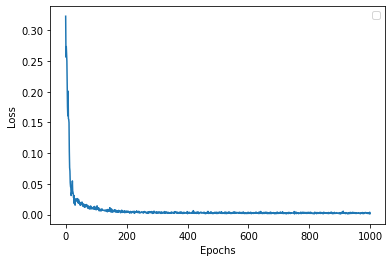

In [ ]:
torch.cuda.empty_cache()
train_SRCNN(args)

Streaming output truncated to the last 5000 lines.
Iteration 1000/6000, G loss: 0.6545177102088928, D loss: 2.9968538001412526e-05
Iteration 1001/6000, G loss: 0.5806796550750732, D loss: 0.001293917652219534
Iteration 1002/6000, G loss: 0.651491641998291, D loss: 0.12338763475418091
Iteration 1003/6000, G loss: 0.7338296175003052, D loss: 0.005930301733314991
Iteration 1004/6000, G loss: 0.6864088773727417, D loss: 0.03583860397338867
Iteration 1005/6000, G loss: 0.6259036064147949, D loss: 0.4324507713317871
Iteration 1006/6000, G loss: 0.6592927575111389, D loss: 0.19167150557041168
Iteration 1007/6000, G loss: 0.641502857208252, D loss: 0.05371622368693352
Iteration 1008/6000, G loss: 0.7329839468002319, D loss: 0.2508074939250946
Iteration 1009/6000, G loss: 0.5713266134262085, D loss: 0.07897740602493286
Iteration 1010/6000, G loss: 0.5729882121086121, D loss: 0.005635078065097332
Iteration 1011/6000, G loss: 0.4974014461040497, D loss: 8.597002306487411e-05
Iteration 1012/6000, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:342: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


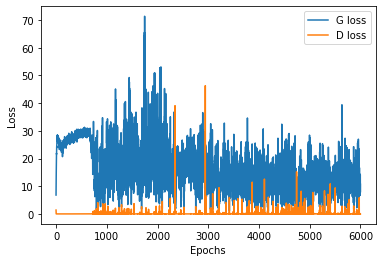

In [ ]:
torch.cuda.empty_cache()
train_ESRGAN(args)

# Test

## Get test data

In [28]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip /content/DIV2K_valid_HR.zip

!wget https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Data/test/selfie2anime.zip
!unzip /content/selfie2anime.zip

!wget https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Data/test/FFHQ.zip
!unzip /content/FFHQ.zip

--2022-04-20 23:18:12--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2022-04-20 23:18:12--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip.1’

DIV2K_valid_HR.zip. 100%[===================>] 428.19M  19.4MB/s    in 17s     

2022-04-20 23:18:30 (24.7 MB/s) - ‘DIV2K_valid_HR.zip.1’ saved [448993893/448993893]

Archive:  /content/DIV2K_valid_HR.zip
replace DIV2K_valid_HR/0897.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  in

In [29]:
# Preprocess div2k valid data set to generate 128x128 images
!rm -rf /content/hr
!mkdir /content/hr
crop_images(128, 128, "DIV2K_valid_HR")

## Helper function

In [30]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import glob

def preprocess_image(image_path, model):
  img = read_image(image_path)
  defalut_size = 64
  if img.shape[1] == img.shape[2]:
    defalut_size = img.shape[1] // 2
  if model == "SRCNN":
    lr_transform = transforms.Compose([transforms.Resize((defalut_size, defalut_size)), 
                                            transforms.Resize((defalut_size*2, defalut_size*2))])
  elif model == "ESRGAN":
    lr_transform = transforms.Compose([transforms.Resize((defalut_size, defalut_size))])

  tensor = lr_transform(torch.tensor(img / 255.))
  return tensor

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  if torch.max(image) < 10:
    image = image * 255.
  plt.imshow(np.transpose(image,(1,2,0)).numpy().astype("uint8"))
  plt.title(title, fontsize=21)
  plt.axis("off")

def PSNR(pred, orig):
  # Calculating PSNR wrt Original Image
  psnr = tf.image.psnr(
      tf.clip_by_value(pred, 0, 255),
      orig,
      max_val=255)
  return psnr

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(0))

import torch.nn.functional as F
from torch.autograd import Variable
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

Using device: Tesla P100-PCIE-16GB


## Load model

### Our model

As the time for training ESRGAN is about 4 hours, we saved the trained models and load them from our GitHub repository every time.

In [48]:
!wget https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Saved_Training_Models/SRCNN_lr_0.0001.pt
!wget https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Saved_Training_Models/ESRGAN_Training_datas/2000iteration/ESRGAN_G_lr_0.0001_no_preceptual.pt


model = SRCNN(args['out_channels'])
if torch.cuda.is_available():
    model.cuda(device)
model.load_state_dict(torch.load('/content/SRCNN_lr_0.0001.pt'))

G = Generator(args['out_channels'])
if torch.cuda.is_available():
    G.cuda(device)
G.load_state_dict(torch.load("/content/ESRGAN_G_lr_0.0001_6000.pt"))

--2022-04-20 23:47:55--  https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Saved_Training_Models/SRCNN_lr_0.0001.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278935 (272K) [application/octet-stream]
Saving to: ‘SRCNN_lr_0.0001.pt.6’

SRCNN_lr_0.0001.pt. 100%[===================>] 272.40K  --.-KB/s    in 0.03s   

2022-04-20 23:47:55 (8.38 MB/s) - ‘SRCNN_lr_0.0001.pt.6’ saved [278935/278935]

--2022-04-20 23:47:56--  https://raw.githubusercontent.com/Sheldonsu28/CSC413-Project/main/Saved_Training_Models/ESRGAN_Training_datas/2000iteration/ESRGAN_G_lr_0.0001_no_preceptual.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw

<All keys matched successfully>

### Pre-trained ESRGAN

The pre-trained ESRGAN is from https://github.com/xinntao/BasicSR

In [39]:
!rm -rf BasicSR
!git clone https://github.com/xinntao/BasicSR.git
%cd BasicSR

Cloning into 'BasicSR'...
remote: Enumerating objects: 5487, done.
remote: Counting objects: 100% (1248/1248), done.
remote: Compressing objects: 100% (548/548), done.
remote: Total 5487 (delta 774), reused 1008 (delta 654), pack-reused 4239
Receiving objects: 100% (5487/5487), 3.64 MiB | 8.83 MiB/s, done.
Resolving deltas: 100% (3341/3341), done.
/content/BasicSR


In [40]:
# Install requirements
!pip install -r requirements.txt
# Install BasicSR without cuda extentions
!python setup.py develop

     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 190 kB 10.5 MB/s 


running develop
running egg_info
creating basicsr.egg-info
writing basicsr.egg-info/PKG-INFO
writing dependency_links to basicsr.egg-info/dependency_links.txt
writing requirements to basicsr.egg-info/requires.txt
writing top-level names to basicsr.egg-info/top_level.txt
writing manifest file 'basicsr.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'basicsr.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/basicsr.egg-link (link to .)
Adding basicsr 1.3.5 to easy-install.pth file

Installed /content/BasicSR
Processing dependencies for basicsr==1.3.5
Searching for yapf==0.32.0
Best match: yapf 0.32.0
Adding yapf 0.32.0 to easy-install.pth file
I

In [ ]:
!python scripts/download_pretrained_models.py ESRGAN

Download 63.8 MB / 63.8 MB: 100% 2043/2043 [00:01<00:00, 1743.96chunk/s]
Download 63.8 MB / 63.8 MB: 100% 2043/2043 [00:01<00:00, 1295.16chunk/s]


## Test

### Pre-trained ESRGAN

In [41]:
def predict_pre_trained_ESRGAN(input_dict, dataset_name):
  # preprocess original image to downsample it
  %cd /content/
  input_list = sorted(glob.glob(os.path.join(input_dict, '*')))
  %rm -rf {dataset_name}_lr
  %rm -rf {dataset_name}_hr
  %mkdir {dataset_name}_lr
  %mkdir {dataset_name}_hr
  for input_path in input_list:
    if '.jpg' in input_path or '.png' in input_path:
      save_image(preprocess_image(input_path, "ESRGAN"),  dataset_name + "_lr/" + os.path.basename(input_path))
  
  # predict using pre-trained model, output will be store at /content/{dataset_name}_hr
  %cd /content/BasicSR
  !python inference/inference_esrgan.py --model_path experiments/pretrained_models/ESRGAN/ESRGAN_SRx4_DF2KOST_official-ff704c30.pth --input /content/{dataset_name}_lr --output /content/{dataset_name}_hr

  # pre-trained model is x4 so we need to down sample again to match the original size
  output_list = sorted(glob.glob(os.path.join("/content/"+dataset_name+"_predict_hr", '*')))
  for output_path in output_list:
    save_image(preprocess_image(output_path, "ESRGAN"),  output_path)

In [ ]:
predict_pre_trained_ESRGAN("/content/hr", "div2k_valid")

In [ ]:
predict_pre_trained_ESRGAN("/content/anime", "anime")

In [ ]:
predict_pre_trained_ESRGAN("/content/FFHQ", "ffhq")

### Our model

In [37]:
%cd /content/
def predict_image(input_path, dataset_name):
  ori_image = read_image(input_path)
  lr_image_srcnn = preprocess_image(input_path, "SRCNN")
  lr_image_esrgan = preprocess_image(input_path, "ESRGAN")

  filename = os.path.basename(input_path).rsplit('.', 1)[0]

  out = model(to_var(lr_image_srcnn[None, :, :, :], device))
  out = out.squeeze(0).cpu().detach()
  save_image(out, "SRCNN_test.png")

  out_G = G(to_var(lr_image_esrgan[None, :, :, :], device))
  out_G = out_G.squeeze(0).cpu().detach()
  save_image(out_G, "ESRGAN_out.png")

  plt.rcParams['figure.figsize'] = [15, 10]
  fig, axes = plt.subplots(2, 3)
  fig.tight_layout()
  plt.subplot(231)
  plot_image(lr_image_srcnn, "Low resolution")
  plt.subplot(232)
  fig.tight_layout()
  plot_image(read_image("SRCNN_test.png"), "Super Res SRCNN")
  plt.subplot(233)
  fig.tight_layout()
  plot_image(read_image("/content/"+dataset_name+"_hr/"+filename+"_ESRGAN.png"), title="Super Res pre-trained ESRGAN")
  plt.subplot(234)
  fig.tight_layout()
  plot_image(ori_image, title="Original resolution")
  plt.subplot(235)
  fig.tight_layout()
  plot_image(read_image("ESRGAN_out.png"), "Super Res ESRGAN")
  fig.delaxes(axes[1,2])
  plt.subplots_adjust(wspace=-0.2)

  print("PSNR Achieved for SRCNN: %f" % PSNR(out, ori_image))
  print("PSNR Achieved for ESRGAN: %f" % PSNR(out_G, ori_image))


/content


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: ignored

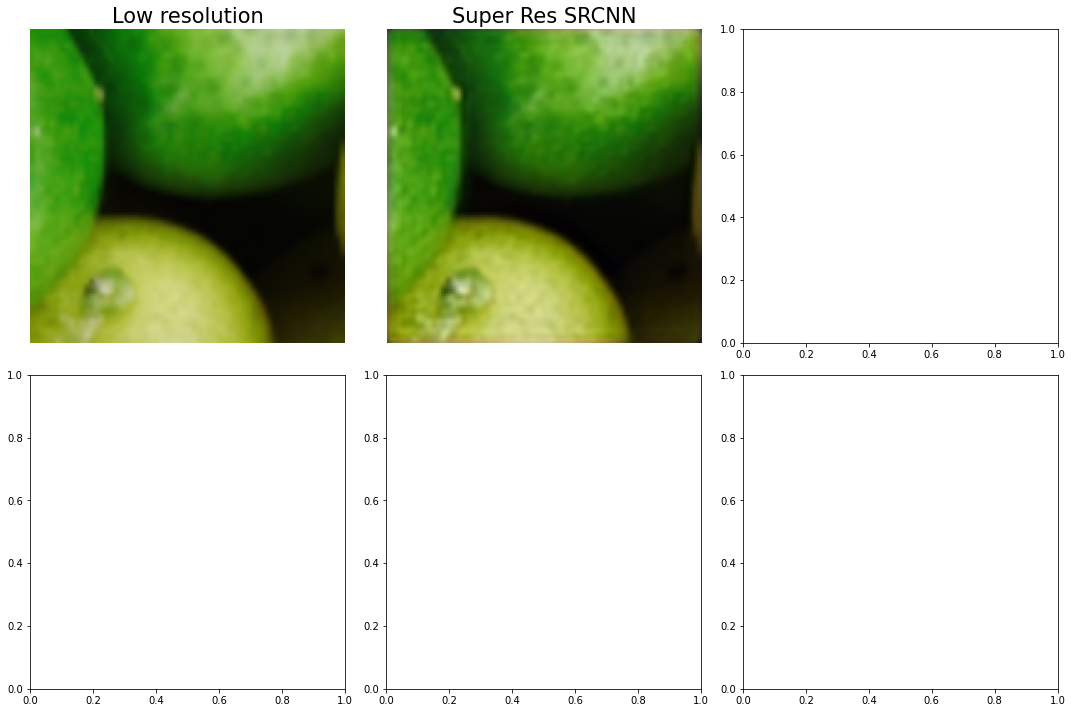

In [ ]:
predict_image("/content/hr/0802.png", "div2k_valid")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: ignored

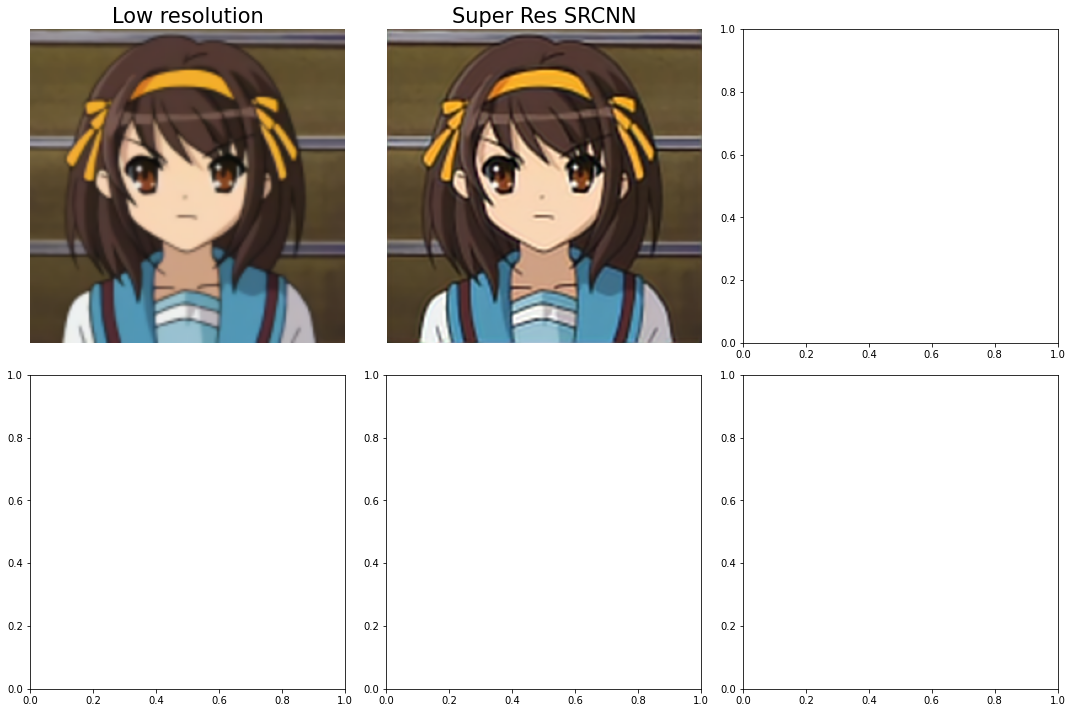

In [ ]:
predict_image("/content/anime/0001.jpg", "anime")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


PSNR Achieved for SRCNN: 75.918259
PSNR Achieved for ESRGAN: 77.240952


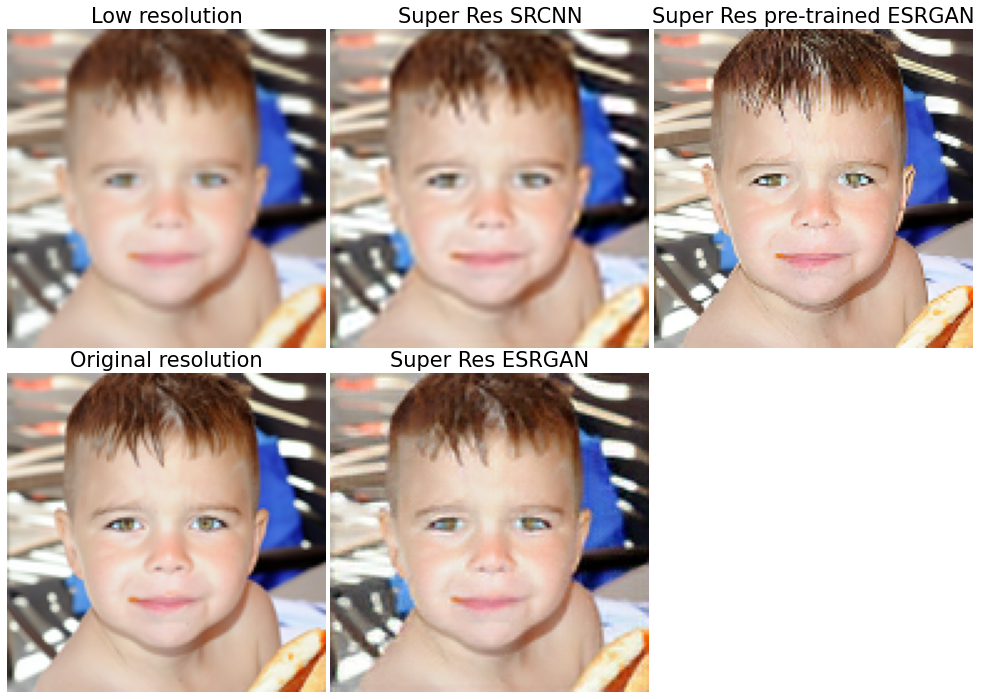

In [ ]:
predict_image("/content/FFHQ/00050.png", "ffhq")

In [ ]:
# test HIV2k, FFHQ, selfie2anime dataset
%cd /content
dataset = 'anime'
default_size = 64
hrs = None

def run_test(hrs, dataset, default_size = 64):
  psnr_srcnn, psnr_esrgan = 0, 0
  ssim_srcnn, ssim_esrgan = 0, 0
  for img in hrs:
    lr_transform_srcnn = transforms.Compose([transforms.Resize((default_size, default_size)), 
                                              transforms.Resize((default_size*2, default_size*2))])
    lr_transform_esrgan = transforms.Compose([transforms.Resize((default_size, default_size))])
    lr_img_srcnn = lr_transform_srcnn(torch.tensor(img))
    lr_img_esrgan = lr_transform_esrgan(torch.tensor(img))
    out1 = model(to_var(lr_img_srcnn[None, :, :, :], device))
    out2 = G(to_var(lr_img_esrgan[None, :, :, :], device))
    out1 = out1.squeeze(0).cpu().detach()
    out2 = out2.squeeze(0).cpu().detach()
    ssim_srcnn += ssim(img.unsqueeze(0), out1.unsqueeze(0))
    ssim_esrgan += ssim(img.unsqueeze(0), out2.unsqueeze(0))
    psnr_srcnn += PSNR(img * 255, out1 * 255)
    psnr_esrgan += PSNR(img * 255, out2 * 255)
  print(f'the average ssim for {dataset} on srcnn is {ssim_srcnn.item() * 100 / len(hrs)}')
  print(f'the average ssim for {dataset} on esrgan is {ssim_esrgan.item() * 100 / len(hrs)}')
  print(f'the average psnr for {dataset} on srcnn is {float(psnr_srcnn) / len(hrs)}')
  print(f'the average psnr for {dataset} on esrgan is {float(psnr_esrgan) / len(hrs)}')

  # names = np.loadtxt('hr/hr.csv', dtype='str', delimiter=", ",
  #                               encoding="utf-8")
  # names = [name for name in names if "csv" not in name]
  # hrs = [read_image(os.path.join('hr', name)).float() / 255.0 for name in names]

names = ['08' + str(i).zfill(2) + '.png' for i in range(1, 100)] + ['0900.png']
hrs = [read_image(os.path.join('hr', name)).float() / 255.0 for name in names]
run_test(hrs, 'HIV2K', 64)

names = [str(i).zfill(5) + '.png' for i in range(1000)]
hrs = [read_image(os.path.join('FFHQ/', name)).float() / 255.0 for name in names]
run_test(hrs, 'FFHQ', 64)

names = [str(i).zfill(4) + '.jpg' for i in range(100)]
hrs = [read_image(os.path.join('anime/', name)).float() / 255.0 for name in names]
run_test(hrs, 'Anime', 128)

/content


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


the average ssim for HIV2K on srcnn is 86.71393585205078
the average ssim for HIV2K on esrgan is 86.92156982421875
the average psnr for HIV2K on srcnn is 29.07026611328125
the average psnr for HIV2K on esrgan is 29.48356201171875
the average ssim for FFHQ on srcnn is 90.73673706054687
the average ssim for FFHQ on esrgan is 91.40786743164062
the average psnr for FFHQ on srcnn is 29.24732421875
the average psnr for FFHQ on esrgan is 30.171466796875
